In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
from scipy import linalg
from scipy import signal
from scipy.signal import butter, filtfilt
from scipy.linalg import eig
from noControl import matrix, TransferFunc, AR_model
from scipy.interpolate import interp1d

In [48]:
def print_structure(name, obj):
    obj_type = "Group" if isinstance(obj, h5py.Group) else "Dataset"
    info = f" | shape: {obj.shape} | dtype: {obj.dtype}" if isinstance(obj, h5py.Dataset) else ""
    print(f"{obj_type}: {name}{info}")

with h5py.File('SaSR_test.hdf5', 'r') as f:
    f.visititems(print_structure)


Group: SR
Dataset: SR/V1:ENV_CEB_SEIS_V | shape: (1800000,) | dtype: float32
Dataset: SR/V1:ENV_CEB_SEIS_V_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F0_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F0_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F1_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F1_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F2_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F2_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F3_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F3_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F4_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F4_LVDT_V_500Hz_dec | shape: (112500,) | dtype: float32
Dataset: SR/V1:Sa_SR_F7_LVDT_V_500Hz | shape: (900000,) | dtype: float32
Dataset: SR/V1:Sa_SR_F7_LVDT_V

In [49]:
with h5py.File('SaSR_test.hdf5', 'r') as f:
    dset = f['SR/V1:ENV_CEB_SEIS_V_dec']
    for key, value in dset.attrs.items():
        print(f"{key}: {value}")

channel: V1:ENV_CEB_SEIS_V_dec
sample_rate: 62.5
t0: 1431561618.0
units: m.s-1


In [50]:
f = h5py.File('SaSR_test.hdf5', 'r')
seism = f['SR/V1:ENV_CEB_SEIS_V_dec'][:]  # The [:] loads the actual data into memory

def data_info(data):
    print('Data loaded from HDF5 file: V1:ENV_CEB_SEIS_V_dec')
    print(f'Shape: {data.shape}') 
    print(f'Dtype: {data.dtype}')
    print(f'Length: {len(data)}')
    print(f'First 5 values: {data[:5]}')
    print(f'Last 5 values: {data[-5:]}')
    print(f'Min value: {data.min()}')
    print(f'Max value: {data.max()}')

data_info(seism)

Data loaded from HDF5 file: V1:ENV_CEB_SEIS_V_dec
Shape: (112500,)
Dtype: float32
Length: 112500
First 5 values: [ -17.462273   -8.134678   59.074474  502.19055  1561.6556  ]
Last 5 values: [203.64767 268.39673 285.65677 240.61739 167.3082 ]
Min value: -3092.741455078125
Max value: 7177.04931640625


In [51]:
seism = seism*1e-6

In [52]:
#constants
nperseg = 2 ** 18 #samples per segment (useful for the PSD)
T = 1800 #signal duration in seconds
#T = 1768  #signal duration when first 2000 samples are removed
# dt = 1/62.5 #sampling frequency
#t = np.linspace(0, T, len(seism)) #time vector
t = np.arange(0, T, 1/62.5)  # time vector based on the duration and sampling frequency
#parameters from noControl.py to be used in the time evolution
dt = 1e-3 #time step


In [53]:
#no point in filtering the data (makes results worse)
# high = 0.2
# order = 4
# b, a = signal.butter(order, Wn=high, btype='lowpass', output='ba', fs=62.5)
# data_filtered = signal.filtfilt(b, a, seism[2000:])

In [54]:
ftransform = np.fft.fft(seism)

frequencies = np.fft.fftfreq(len(seism), d = 1/62.5)
half = len(frequencies) // 2 #half the length of the frequencies array

X_f = np.zeros_like(ftransform, dtype=complex) #create an array of zeros with the same shape as V
nonzero = frequencies != 0 #boolean mask: true if freq is not zero
#for all non-zero frequencies, divide the FT by 2 pi f the take the IFT to get the displacement
X_f[nonzero] = ftransform[nonzero] / (1j * 2 * np.pi * frequencies[nonzero])
zt = np.fft.ifft(X_f)


#multiply the FT by 2 pi f then take the IFT to get the acceleration
acc = ftransform * (frequencies * 2 * np.pi * 1j)
At = np.fft.ifft(acc)


#calculate the PSDs to plot the velocity and acceleration spectra
fAcc, psdAcc = signal.welch(At.real, fs =62.5, window='hann', nperseg=nperseg)
fVel, psdVel = signal.welch(seism.real, fs =62.5, window='hann', nperseg=nperseg)
fZ, psdZ = signal.welch(zt.real, fs =62.5, window='hann', nperseg=nperseg)


/Users/letizia/miniconda3/envs/infn/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 262144 is greater than input length  = 112500, using nperseg = 112500
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


In [55]:
fs = 62.5  # Sampling frequency
N = len(seism)  # Total number of samples
vf = np.fft.fft(seism * np.hanning(N))  # Apply window to reduce leakage
freqs = np.fft.fftfreq(N, d=1/fs)
print(freqs[:half])

[0.00000000e+00 5.55555556e-04 1.11111111e-03 ... 3.12483333e+01
 3.12488889e+01 3.12494444e+01]


In [56]:

# One-sided PSD (for real-valued signals)
half = N // 2
psd = (1 / (fs * N)) * np.abs(vf[:half])**2
freqs = freqs[:half]

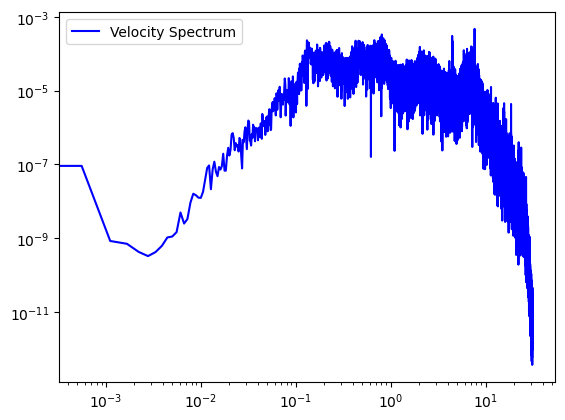

In [57]:
plt.loglog(freqs[:half], np.sqrt(psd), label='Velocity Spectrum', color='blue')
plt.legend()
plt.show()

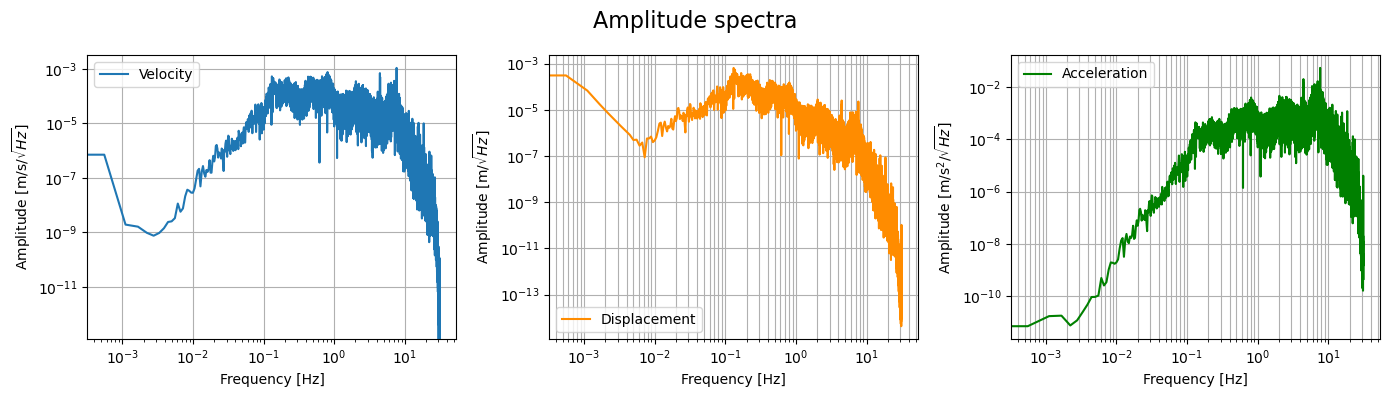

In [58]:
plt.figure(figsize=(14, 4))

plt.suptitle('Amplitude spectra', fontsize=16)

plt.subplot(1, 3, 1)
plt.loglog(fVel, np.sqrt(psdVel), label='Velocity')
plt.ylabel('Amplitude [m/s/$\sqrt{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.loglog(fZ, np.sqrt(psdZ), label='Displacement', color='darkorange')
plt.ylabel('Amplitude [m/$\sqrt{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.grid(which = 'both', axis = 'both')
plt.legend()

plt.subplot(1, 3, 3)
plt.loglog(fAcc, np.sqrt(psdAcc), label ='Acceleration', color='green')
plt.ylabel('Amplitude [m/s$^2$/$\sqrt{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.grid(which = 'both', axis = 'both')
plt.legend()
plt.tight_layout()
plt.show()

## Vertical control

In [59]:
def force_function(t, mass, acceleration):
    return mass * np.real(acceleration)


In [60]:
def evolution(evol_method, Nt_step, dt, physical_params, signal_params,
              F, file_name = None):
    """
    Simulates the temporal evolution of the system under the influence of an
    external force.

    Parameters
    ----------
    evol_method : function
        The function used to evolve the system (e.g. Euler or ARMA methods).
    Nt_step : int
        The number of temporal steps to simulate.
    dt : float
        The time step size.
    physical_params : list
        The list of physical parameters for the system.
    signal_params : list
        The list of parameters for the external force signal.
    F : function
        The function modeling the external force.
    file_name : str, optional
        The name of the file to save simulation data. Default is None.

    Returns
    -------
    tuple
        A tuple containing the time grid and the arrays of velocities
        and positions for each mass.
    """
    # Initialize the problem
    tmax = Nt_step * dt  # maximum time
    tt = np.arange(0, tmax, dt)  # time grid
    #tt = np.arange(0, 1768, 1/62.5)
    y0 = np.array(
        (0, 0, 0, 0, 0, 0, 0., 0., 0., 0., 0., 0.))  # initial condition
    y_t = np.copy(y0)  # create a copy to evolve it in time
    F_signal = F(tt, *signal_params)  # external force applied over time 


    # Initialize lists for velocities and positions
    v1, v2, v3, v4, v5, v6 = [[], [], [], [], [], []]
    x1, x2, x3, x4, x5, x6 = [[], [], [], [], [], []]

    # compute the system matrices
    A, B = matrix(*physical_params)

    # time evolution when the ext force is applied
    i = 0
    for t in tt:
        Fi = F_signal[i]  # evaluate the force at time t
        i = i + 1
        y_t = evol_method(y_t, A, B, Fi)  # evolve to step n+1
        v1.append(y_t[0])
        v2.append(y_t[1])
        v3.append(y_t[2])
        v4.append(y_t[3])
        v5.append(y_t[4])
        v6.append(y_t[5])
        x1.append(y_t[6])
        x2.append(y_t[7])
        x3.append(y_t[8])
        x4.append(y_t[9])
        x5.append(y_t[10])
        x6.append(y_t[11])

    # save simulation's data (if a file name is provided)
    if file_name is not None:
        data = np.column_stack((tt, v1, v2, v3, v4, v5, v6,
                                x1, x2, x3, x4, x5, x6))
       # np.savetxt(os.path.join(data_dir, file_name), data,
        #           header='time, v1, v2, v3, v4, v5, v6, x1, x2, x3, x4, x5, x6')

    return (tt, np.array(v1), np.array(v2), np.array(v3), np.array(v4),
            np.array(v5), np.array(v6), np.array(x1), np.array(x2),
            np.array(x3), np.array(x4), np.array(x5), np.array(x6))



In [61]:
Nt_step = 112500  #temporal steps


# Parameters of the system
gamma = [5, 5, 5, 5, 5]  # viscous friction coeff [kg/m*s]
M = [160, 125, 120, 110, 325, 82]  # filter mass [Kg]
K = [700, 1500, 3300, 1500, 3400, 564]  # spring constant [N/m]

F = force_function
 # angular frequencies for the first half of the spectrum
wn = 2*np.pi*frequencies
tmax = Nt_step * dt  
tt_sim = np.arange(0, tmax, dt)

# Interpolation
interp_acc = interp1d(t, At, kind='linear', bounds_error=False, fill_value=0.0)
At_interp = interp_acc(tt_sim)
print(len(At),len(At_interp), len(tt_sim))  

#print(freq[7]-freq[6])   #0.0030517578125 Hz
# Simulation 
physical_params = [*M, *K, *gamma, dt]
simulation_params = [AR_model, Nt_step, dt] 
signal_params = [M[0], At] 
#signal_params = [M[0], At_interp]  
#tt = np.linspace(0, Nt_step * dt, Nt_step, endpoint=False)

tt, v1, v2, v3, v4, v5, v6, x1, x2, x3, x4, x5, x6 = (
                        evolution(*simulation_params, physical_params, signal_params,
                        F, file_name = None))

Tf, poles = TransferFunc(wn, *M, *K, *gamma)
x6_interp = interp1d(tt_sim, x6, kind='linear', bounds_error=False, fill_value=0.0)(t)
v6_interp = interp1d(tt_sim, v6, kind='linear', bounds_error=False, fill_value=0.0)(t)
# Compute the magnitude of the transfer function
#(modulus squared) square rooted
H = (np.real(Tf) ** 2 + np.imag(Tf) ** 2) ** (1 / 2)
print(len(Tf), len(H[5]), len(wn))

112500 112500 112500
6 112500 112500


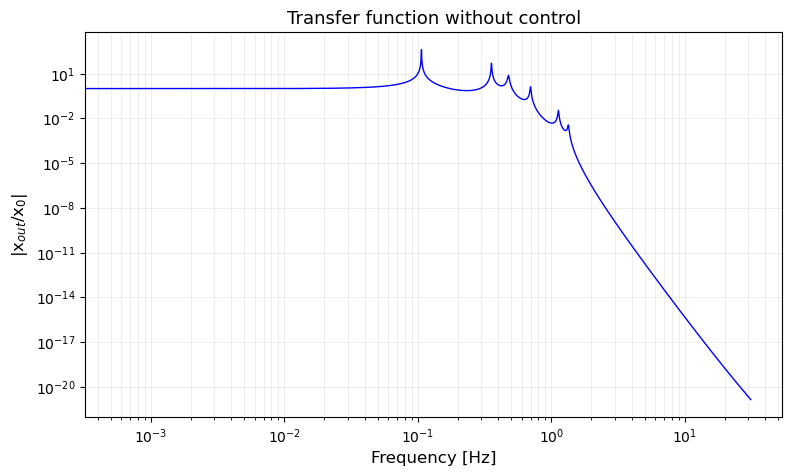

In [62]:
fig = plt.figure(figsize=(9, 5))
plt.title('Transfer function without control', size=13)
plt.xlabel('Frequency [Hz]', size=12)
plt.ylabel('|x$_{out}$/x$_0$|', size=12)
plt.yscale('log')
plt.xscale('log')
plt.grid(True, which='both', ls='-', alpha=0.3, lw=0.5)
plt.minorticks_on()

plt.plot(frequencies[:half], H[5][:half], linestyle='-', linewidth=1, marker='', color='blue')
#plt.plot(abs(frequencies), H[5], linestyle='-', linewidth=1, marker='', color='steelblue', label='output $x_{pl}$')

plt.show()

In [63]:
window = np.hanning(len(zt))
xf_out = np.fft.fft(x6_interp)
#xf_in = X_f
xf_in = np.fft.fft(zt)
#vf_in = np.fft.fft(seism)  #vf_in = ftransform
vf_out = np.fft.fft(v6_interp)

In [64]:
vTF = vf_out/np.fft.fft(seism)
vH = (np.real(vTF) ** 2 + np.imag(vTF) ** 2) ** (1 / 2) 
vH_mag = np.abs(vH)

In [65]:
xTF = xf_out / np.fft.fft(zt)
xH = (np.real(xTF) ** 2 + np.imag(xTF) ** 2) ** (1 / 2)
xH_mag = np.abs(xH)

In [66]:
frequencies[:half]

array([0.00000000e+00, 5.55555556e-04, 1.11111111e-03, ...,
       3.12483333e+01, 3.12488889e+01, 3.12494444e+01])

In [67]:
fVel

array([0.00000000e+00, 5.55555556e-04, 1.11111111e-03, ...,
       3.12488889e+01, 3.12494444e+01, 3.12500000e+01])

In [68]:
psdVel_interpolated = interp1d(fVel, psdVel, kind='linear', bounds_error=False, fill_value=0.0)(frequencies)
psdAcc_interpolated = interp1d(fAcc, psdAcc, kind='linear', bounds_error=False, fill_value=0.0)(frequencies)
psdZ_interpolated = interp1d(fZ, psdZ, kind='linear', bounds_error=False, fill_value=0.0)(frequencies)

In [69]:
xout_frequency_domain = np.fft.fft(zt*window) * H[5]  # output in frequency domain (xout)
xout_time_domain = np.fft.ifft(xout_frequency_domain)
vout_frequency_domain = np.fft.fft(seism*window) * H[5] # output in frequency domain (vout)
vout_time_domain = np.fft.ifft(vout_frequency_domain)
acc_out_frequency_domain = np.fft.fft(At*window) * H[5]
acc_out_time_domain = np.fft.ifft(acc_out_frequency_domain)

In [70]:
transfer_function_velocity = vout_frequency_domain / ftransform
transfer_function_displacement = xout_frequency_domain / X_f
transfer_function_acceleration = acc_out_frequency_domain / acc

/var/folders/71/wnl968493yj4fx2dn98rmpsh0000gn/T/ipykernel_71898/108149081.py:2: RuntimeWarning: divide by zero encountered in divide
  transfer_function_displacement = xout_frequency_domain / X_f
/var/folders/71/wnl968493yj4fx2dn98rmpsh0000gn/T/ipykernel_71898/108149081.py:3: RuntimeWarning: divide by zero encountered in divide
  transfer_function_acceleration = acc_out_frequency_domain / acc


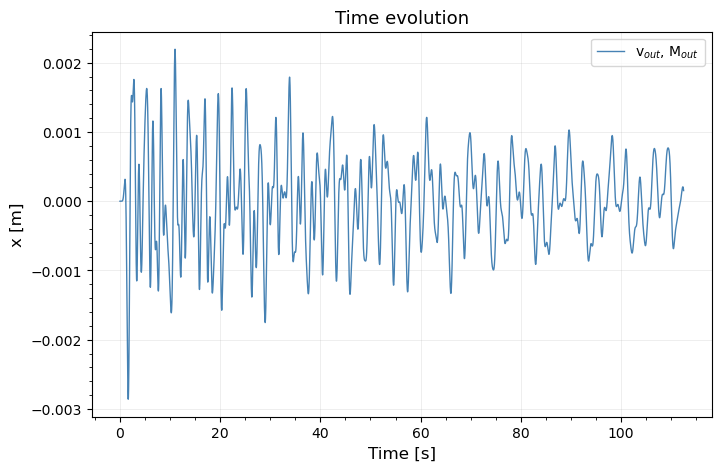

In [71]:
# ------------------------------Plot time evolution------------------------#
# # save time evol in a file (for the first and last mass)
# np.savetxt(os.path.join(data_dir, 'timeEvol_noControl.txt'),
#             np.column_stack((tt, x1, x6)), header='time[s], x1, x6')

fig = plt.figure(figsize=(8, 5))
plt.title('Time evolution', size=13)
plt.xlabel('Time [s]', size=12)
plt.ylabel('x [m]', size=12)
plt.grid(True, ls='-', alpha=0.3, lw=0.5)
plt.minorticks_on()

#plt.plot(tt, x1, linestyle='-', linewidth=1, marker='', color='steelblue', label='x1, M$_1$')
#plt.plot(tt, x2, linestyle='-', linewidth=1, marker='', color='black', label='x2, M$_2$')
#plt.plot(tt, x3, linestyle='-', linewidth=1, marker='', color='red', label='x3, M$_3$')
#plt.plot(tt, x4, linestyle='-', linewidth=1, marker='', color='green', label='x4, M$_4$')
#plt.plot(tt, x5, linestyle='-', linewidth=1, marker='', color='darkmagenta', label='x7, M$_7$')
plt.plot(tt, v6, linestyle='-', linewidth=1, marker='',color='steelblue', label='v$_{out}$, M$_{out}$') #ultima massa
#plt.plot(t, x6_interp, linestyle='-', linewidth=1, marker='',color='green', label='x$_{out}$, M$_{out}$', alpha = 0.7) #ultima massa


#plt.plot(tt_data, v6_interp, linestyle='--', linewidth=1, marker='', color='darkorange', label='x$_{out}$, M$_{out}$ (transfer function)')
plt.legend()
plt.show()



In [72]:
max(tt)

112.49900000000001

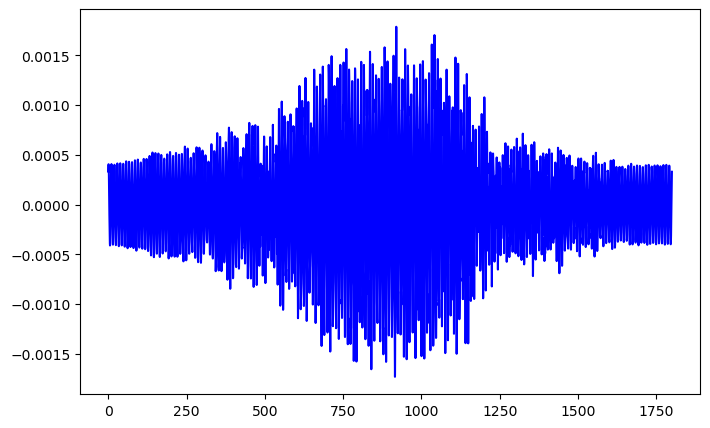

In [73]:
plt.figure(figsize=(8, 5))
plt.plot(t, (xout_time_domain).real, label='xout (time domain)', color='blue')
#plt.xlim(0, 200)
plt.show()

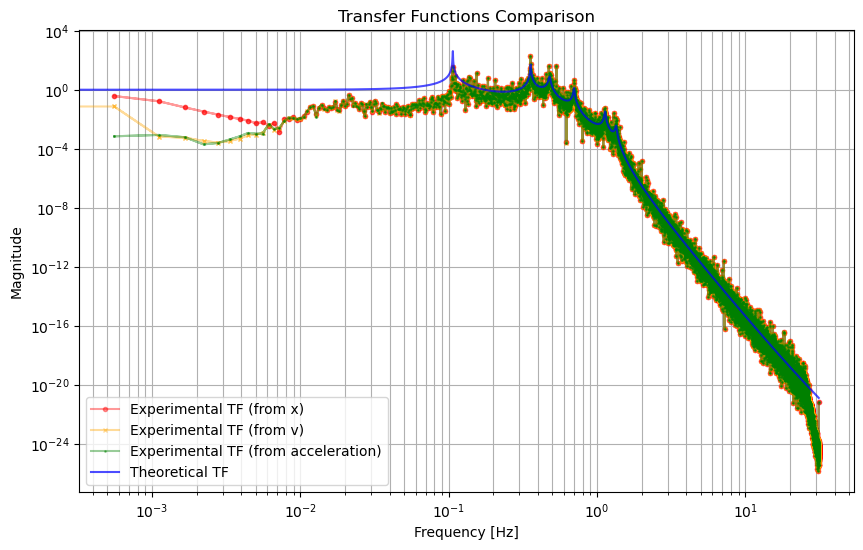

In [87]:
# Plot it alongside the theoretical one
plt.figure(figsize=(10, 6))
# plt.loglog(abs(frequencies),abs(Tf[5]), label="Theoretical TF", color="blue")
plt.loglog(abs(frequencies), abs(transfer_function_displacement), label="Experimental TF (from x)", color="red", alpha=0.4, marker='o', markersize=3)
plt.loglog(abs(frequencies), abs(transfer_function_velocity), label="Experimental TF (from v)", color="orange", alpha=0.4, marker='x', markersize =3)
plt.loglog(abs(frequencies), abs(transfer_function_acceleration), label="Experimental TF (from acceleration)", color="green", alpha=0.4, marker='.', markersize=2)
plt.loglog(frequencies[:half],H[5][:half], label="Theoretical TF", color="blue", alpha =0.7, linewidth=1.5)


plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid(True, which='both')
plt.legend()
plt.title("Transfer Functions Comparison")
#plt.ylim(1e-21, 1e5)
plt.show()

In [75]:
#compute acceleration from output v6
#interp_v6 = interp1d(tt_sim, v6, kind='linear', bounds_error=False, fill_value=0.0)
#v6_resampled = interp_v6(t)
v6_FT = np.fft.fft(v6_interp)
v6_freq = np.fft.fftfreq(len(v6), d = 1/62.5)

acc_out =  v6_FT * (v6_freq * 2 * np.pi * 1j) #acceleration nel dominio delle frequenze

A_out = np.fft.ifft(acc_out) #time domain

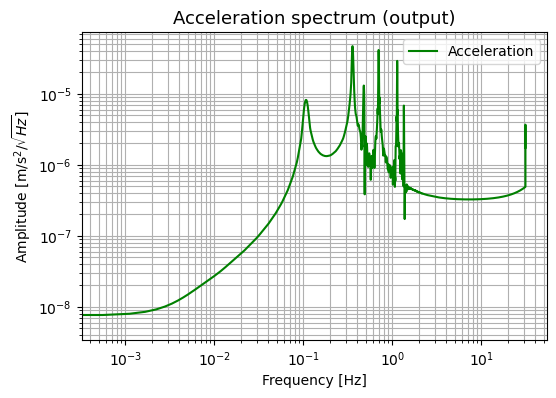

In [76]:
#generate ASD
fAcc_out, psdAcc_out = signal.welch(A_out.real, fs =62.5, nperseg=nperseg)
plt.figure(figsize=(6, 4))
plt.title('Acceleration spectrum (output)', fontsize=13)
plt.loglog(fAcc_out, np.sqrt(psdAcc_out), label ='Acceleration', color='green')
plt.ylabel('Amplitude [m/s$^2$/$\sqrt{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.grid(which = 'both', axis = 'both')
plt.legend()
plt.show()


In [77]:
f_x6_out, psd_x6_out = signal.welch(x6_interp, fs =62.5, window='hann', nperseg=nperseg)


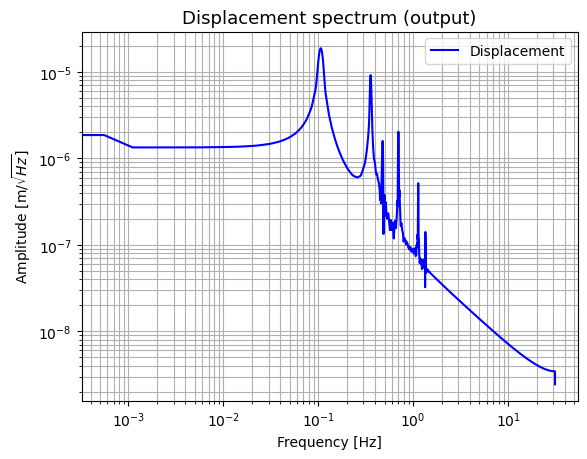

In [78]:
plt.loglog(f_x6_out, np.sqrt(psd_x6_out), label ='Displacement', color='blue')
plt.ylabel('Amplitude [m/$\sqrt{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.grid(which = 'both', axis = 'both')
plt.title('Displacement spectrum (output)', fontsize=13)
plt.legend()
plt.show()

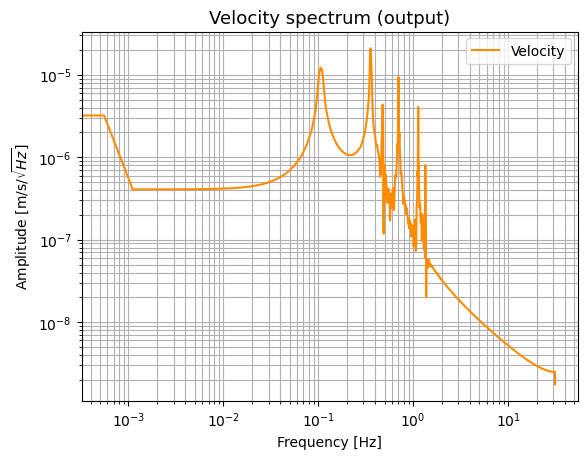

In [79]:
f_v6_out, psd_v6_out = signal.welch(v6_interp, fs =62.5, window='hann', nperseg=nperseg)
plt.loglog(f_v6_out, np.sqrt(psd_v6_out), label ='Velocity', color='darkorange')
plt.ylabel('Amplitude [m/s/$\sqrt{Hz}$]')
plt.xlabel('Frequency [Hz]')
plt.grid(which = 'both', axis = 'both')
plt.title('Velocity spectrum (output)', fontsize=13)
plt.legend()
plt.show()

## Data augmentation

codice da rivedere

In [80]:
def generate_noisy_seismic_versions(seism_original, num_versions, sigma=1/np.sqrt(2), seed=None):
    """
    Generate multiple complex-noise-augmented versions of a seismic signal.

    Parameters:
    -----------
    seism_original : np.ndarray
        Original seismic signal (real or complex).
    num_versions : int
        Number of noisy versions to generate.
    sigma : float
        Standard deviation of Gaussian noise.
    seed : int or None
        Optional seed for reproducibility.

    Returns:
    --------
    seism_augmented_list : list of np.ndarray
        List of complex-valued noisy seismic signals.
    """
    if seed is not None:
        np.random.seed(seed)

    seism_augmented_list = []
    for _ in range(num_versions):
        zbar = np.random.normal(0, sigma, len(seism_original)) + 1j * np.random.normal(0, sigma, len(seism_original))
        seism_noisy = seism_original * zbar
        seism_augmented_list.append(seism_noisy)

    return seism_augmented_list

In [81]:
num_versions = 10
seism_original = seism.copy() 
augmented_signals = generate_noisy_seismic_versions(seism_original, num_versions)

# Use the first one
seism_generated = augmented_signals[0]  

Text(0.5, 1.0, 'Generated Seismic Signal (Real Part)')

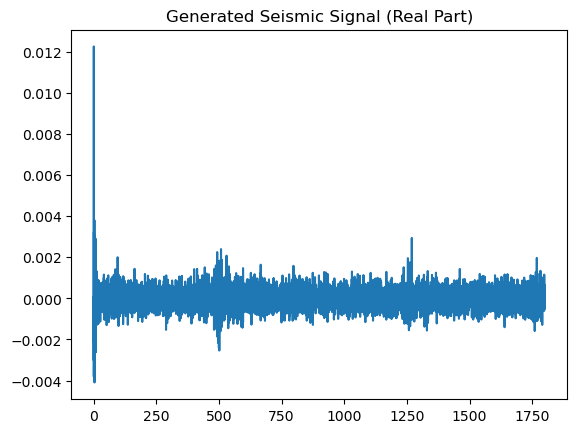

In [82]:
plt.plot(t,seism_generated.real)
plt.title('Generated Seismic Signal (Real Part)')


In [83]:
num_versions = 5
vHfn_all = []
xHfn_all = []
sigma = 1/np.sqrt(2)  # Standard deviation for noise
for i in range(num_versions):
    # Generate noisy signal
    zbar = np.random.normal(0, sigma, len(seism)) + 1j * np.random.normal(0, sigma, len(seism))
    seism_noisy = seism_original * zbar

    # Recalculate FFT and displacement/acceleration
    ftransform = np.fft.fft(seism_noisy)
    X_f = np.zeros_like(ftransform, dtype=complex)
    nonzero = frequencies != 0
    X_f[nonzero] = ftransform[nonzero] / (1j * 2 * np.pi * frequencies[nonzero])
    zt = np.fft.ifft(X_f)
    acc = ftransform * (frequencies * 2 * np.pi * 1j)
    At = np.fft.ifft(acc)

    # Interpolate acceleration to simulation time grid
    At_interp = interp1d(t, At, kind='linear', bounds_error=False, fill_value=0.0)(tt_sim)
    Nt_step = 112500  #temporal steps


# Parameters of the system
    gamma = [5, 5, 5, 5, 5]  # viscous friction coeff [kg/m*s]
    M = [160, 125, 120, 110, 325, 82]  # filter mass [Kg]
    K = [700, 1500, 3300, 1500, 3400, 564]  # spring constant [N/m]

    F = force_function
 # angular frequencies for the first half of the spectrum
    wn = 2*np.pi*frequencies
    tmax = Nt_step * dt  
    t_sim = np.arange(0, tmax, dt)
    # Run simulation
    physical_params = [*M, *K, *gamma, dt]
    simulation_params = [AR_model, Nt_step, dt] 
    signal_params = [M[0], At]
    tt, v1, v2, v3, v4, v5, v6, x1, x2, x3, x4, x5, x6 = (
                        evolution(*simulation_params, physical_params, signal_params,
                        F, file_name = None))

    # Interpolate x6 back to data grid
    x6_interp = interp1d(tt_sim, x6, kind='linear', bounds_error=False, fill_value=0.0)(t)
    v6_interp = interp1d(tt_sim, v6, kind='linear', bounds_error=False, fill_value=0.0)(t)
    # FFT of input and output

    window = np.hanning(len(zt))
    xf_out = np.fft.fft(x6_interp)
#xf_in = X_f
    xf_in = np.fft.fft(zt)
#vf_in = np.fft.fft(seism)  #vf_in = ftransform
    vf_out = np.fft.fft(v6_interp)
    vTF = vf_out/np.fft.fft(seism)

    vH = (np.real(vTF) ** 2 + np.imag(vTF) ** 2) ** (1 / 2) 
    vH_mag = np.abs(vH)

    xTF = xf_out / np.fft.fft(zt)
    xH = (np.real(xTF) ** 2 + np.imag(xTF) ** 2) ** (1 / 2)
    xH_mag = np.abs(xH)
    
    vHfn_all.append(vH_mag)
    xHfn_all.append(xH_mag)

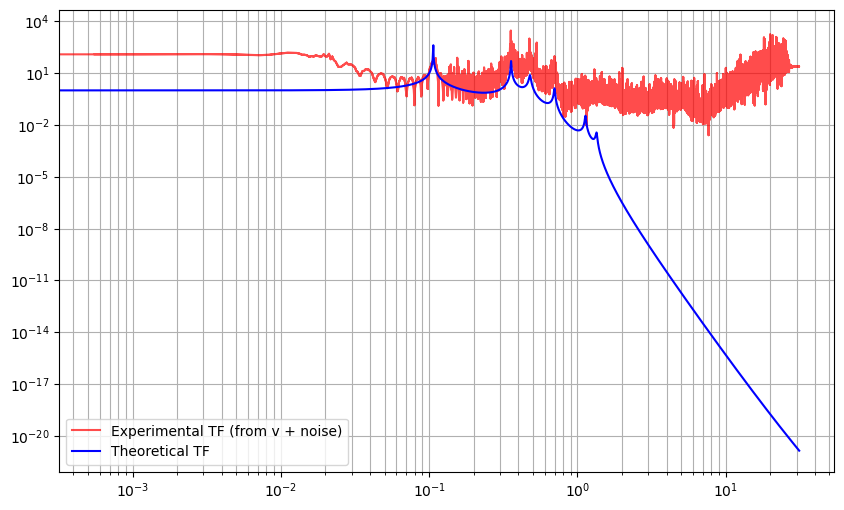

In [84]:
plt.figure(figsize=(10, 6))
# plt.loglog(abs(frequencies),abs(Tf[5]), label="Theoretical TF", color="blue")
plt.loglog(abs(frequencies), vHfn_all[0], label="Experimental TF (from v + noise)", color="red", alpha=0.7)
# #plt.loglog(abs(frequencies), abs(xTF), label="Experimental TF (from x)", color="green", alpha=0.7)
plt.loglog(frequencies[:half],H[5][:half], label="Theoretical TF", color="blue")
plt.grid(which='both')
plt.legend()
plt.show()

In [85]:
#Hfn_all = np.array(Hfn_all)
Hfn_avg = np.abs(np.mean(vHfn_all, axis=0))
Hfn_std = np.std(np.abs(vHfn_all), axis=0)

Text(0.5, 1.0, 'Transfer Function (Averaged over Augmentations)')

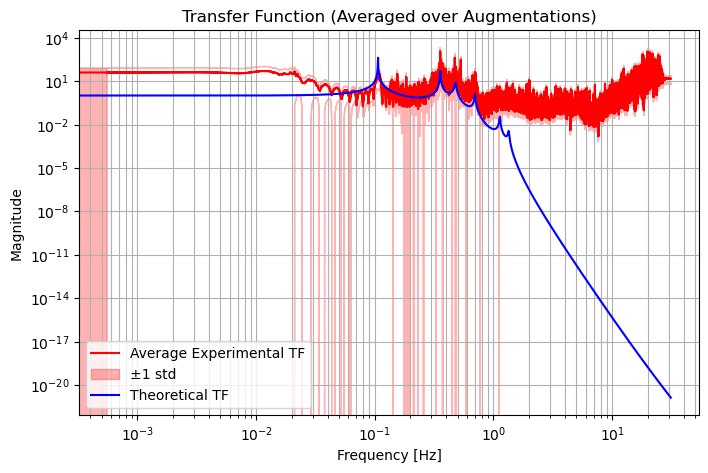

In [86]:
plt.figure(figsize=(8, 5))
plt.loglog(abs(frequencies), Hfn_avg, label="Average Experimental TF", color="red")
plt.fill_between(abs(frequencies), Hfn_avg - Hfn_std, Hfn_avg + Hfn_std, 
                 color="red", alpha=0.3, label="±1 std")
plt.loglog(frequencies[:half], H[5][:half], label="Theoretical TF", color="blue")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid(True, which='both')
plt.legend()
plt.title("Transfer Function (Averaged over Augmentations)")